In [2]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.3.1"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.3.1) to /private/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/pip-install-zfnodc2p/granite-tsfm_cd5d1c4a1449406f82f6296b8a162271
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /private/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/pip-install-zfnodc2p/granite-tsfm_cd5d1c4a1449406f82f6296b8a162271
  Running command git checkout -q 16106d70d1fb3244eecd48c8fbbf3a0009fb8751
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 16106d70d1fb3244eecd48c8fbbf3a0009fb8751
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# TSPulse Anomaly Detection for OBD-II Vehicle Sensor Fault Detection

This notebook adapts IBM TSPulse for detecting **Engine Coolant Temperature sensor failures** in OBD-II vehicle telemetry data as part of the Granite Guardian project.

## Dataset Overview

**KIT Dataset**: Normal driving data (2.7M rows, 10 Hz sampling)
- File: `2018-03-26_Seat_Leon_RT_S_Normal.csv`
- Contains normal vehicle operation data only

and **CarOBD Dataset** (no anomalies or faults, 1hz sampling)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix, f1_score

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline

In [4]:
def load_kit_data(file_path, features=None, max_rows=None):
    """
    Load KIT dataset with proper preprocessing for TSPulse.
    
    Args:
        file_path: Path to KIT CSV file
        features: List of feature columns to use
        max_rows: Maximum number of rows to load (for testing)
    
    Returns:
        pandas.DataFrame: Preprocessed data
    """
    print(f"Loading KIT data from: {file_path}")
    
    # Load data
    df = pd.read_csv(file_path)
    print(f"Original data shape: {df.shape}")
    
    # Convert time column to datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')
    
    # Handle missing values - forward fill for vehicle sensors
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Select features if specified
    if features:
        available_features = [col for col in features if col in df.columns]
        missing_features = [col for col in features if col not in df.columns]
        
        if missing_features:
            print(f"Warning: Missing features: {missing_features}")
        
        df = df[['Time'] + available_features]
        print(f"Selected features: {available_features}")
    
    # Limit rows if specified
    if max_rows:
        df = df.head(max_rows)
        print(f"Limited to {max_rows} rows")
    
    print(f"Final data shape: {df.shape}")
    print(f"Data range: {df['Time'].min()} to {df['Time'].max()}")
    
    return df

def preprocess_for_tspulse(df, target_column='Engine Coolant Temperature [°C]'):
    """
    Preprocess data for TSPulse anomaly detection.
    
    Args:
        df: Input dataframe
        target_column: Primary target column for anomaly detection
    
    Returns:
        pandas.DataFrame: Preprocessed data ready for TSPulse
    """
    print(f"Preprocessing data for TSPulse anomaly detection...")
    print(f"Target column: {target_column}")
    
    # Create a copy
    df_processed = df.copy()
    
    # Remove time column for TSPulse (it expects only numerical features)
    if 'Time' in df_processed.columns:
        df_processed = df_processed.drop('Time', axis=1)
    
    # Check for target column
    if target_column not in df_processed.columns:
        print(f"Warning: Target column '{target_column}' not found!")
        print(f"Available columns: {list(df_processed.columns)}")
        return None
    
    # Remove any remaining non-numeric columns
    numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
    df_processed = df_processed[numeric_columns]
    
    # Final data validation
    print(f"Processed data shape: {df_processed.shape}")
    print(f"Features: {list(df_processed.columns)}")
    print(f"Data types: {df_processed.dtypes.to_dict()}")
    
    # Check for any remaining NaN values
    nan_count = df_processed.isnull().sum().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values found, filling with forward fill")
        df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
    
    return df_processed

In [5]:
# Dataset paths
kit_data_path = "data/KIT/dataset/OBD-II-Dataset/2018-03-26_Seat_Leon_RT_S_Normal.csv"

# Key sensor columns for multivariate analysis
kit_features = [
    'Engine Coolant Temperature [°C]',  # Primary target
    'Engine RPM [RPM]',
    'Vehicle Speed Sensor [km/h]',
    'Absolute Throttle Position [%]',
    'Intake Manifold Absolute Pressure [kPa]',
    'Air Flow Rate from Mass Flow Sensor [g/s]'
]


print("Dataset paths configured:")
print(f"KIT normal data: {kit_data_path}")

# Load and preprocess KIT dataset for TSPulse
print("=== Loading KIT Dataset ===")

kit_data = load_kit_data(kit_data_path, features=kit_features)  # Limit for testing
print("\n=== Preprocessing for TSPulse ===")

# For TSPulse, we need to keep the Time column and ensure proper formatting
if kit_data is not None:
    # Ensure time column is properly formatted 
    kit_data['Time'] = pd.to_datetime(kit_data['Time'], format='%DD%M:%S.%f')
    
    # Handle missing values
    kit_data = kit_data.fillna(method='ffill').fillna(method='bfill')
    
    # Select only the columns we need for TSPulse
    tspulse_columns = ['Time'] + kit_features
    available_columns = [col for col in tspulse_columns if col in kit_data.columns]
    kit_processed = kit_data[available_columns].copy()
    
    print(f"TSPulse data shape: {kit_processed.shape}")
    print(f"Columns: {list(kit_processed.columns)}")
    
    # Display basic statistics
    print("\n=== Data Statistics ===")
    print(kit_processed.describe())
    
    # Check coolant temperature specifically
    coolant_col = 'Engine Coolant Temperature [°C]'
    if coolant_col in kit_processed.columns:
        print(f"\n=== Coolant Temperature Analysis ===")
        print(f"Coolant temp range: {kit_processed[coolant_col].min():.1f}°C to {kit_processed[coolant_col].max():.1f}°C")
        print(f"Coolant temp mean: {kit_processed[coolant_col].mean():.1f}°C")
        print(f"Coolant temp std: {kit_processed[coolant_col].std():.1f}°C")
else:
    print("Error: Could not load KIT data")
    kit_processed = None


Dataset paths configured:
KIT normal data: data/KIT/dataset/OBD-II-Dataset/2018-03-26_Seat_Leon_RT_S_Normal.csv
=== Loading KIT Dataset ===
Loading KIT data from: data/KIT/dataset/OBD-II-Dataset/2018-03-26_Seat_Leon_RT_S_Normal.csv
Original data shape: (33563, 11)
Selected features: ['Engine Coolant Temperature [°C]', 'Engine RPM [RPM]', 'Vehicle Speed Sensor [km/h]', 'Absolute Throttle Position [%]', 'Intake Manifold Absolute Pressure [kPa]', 'Air Flow Rate from Mass Flow Sensor [g/s]']
Final data shape: (33563, 7)
Data range: 1900-01-01 07:17:05.131000 to 1900-01-01 08:04:43.289000

=== Preprocessing for TSPulse ===
TSPulse data shape: (33563, 7)
Columns: ['Time', 'Engine Coolant Temperature [°C]', 'Engine RPM [RPM]', 'Vehicle Speed Sensor [km/h]', 'Absolute Throttle Position [%]', 'Intake Manifold Absolute Pressure [kPa]', 'Air Flow Rate from Mass Flow Sensor [g/s]']

=== Data Statistics ===
                                Time  Engine Coolant Temperature [°C]  \
count              

/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/ipykernel_37628/2237120453.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/ipykernel_37628/3979704761.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  kit_data = kit_data.fillna(method='ffill').fillna(method='bfill')


In [6]:
# TSPulse Model Setup for Anomaly Detection
print("=== Setting up TSPulse Model ===")

# Initialize TSPulse model for reconstruction
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    num_input_channels=6, 
    revision="main",
    mask_type="user",
)

config = {
    "prediction_mode": [AnomalyScoreMethods.PREDICTIVE.value], # removed AnomalyScoreMethods.FREQUENCY_RECONSTRUCTION
    "aggregation_length": 16, 
    "aggregation_function": "mean", 
    "smoothing_length": 1, 
    "least_significant_scale": 0.02, 
    "least_significant_score": 0.2
}

# Configure anomaly detection pipeline for KIT dataset
pipeline = TimeSeriesAnomalyDetectionPipeline(
    model,
    timestamp_column="Time",  # KIT dataset time column
    target_columns=[
        "Engine Coolant Temperature [°C]",  # Primary target for coolant anomalies
        "Engine RPM [RPM]",
        "Vehicle Speed Sensor [km/h]",
        "Absolute Throttle Position [%]",
        "Intake Manifold Absolute Pressure [kPa]",
        "Air Flow Rate from Mass Flow Sensor [g/s]"
    ],
    prediction_mode=config["prediction_mode"],
    aggregation_length=config["aggregation_length"], 
    aggr_function=config["aggregation_function"], 
    smoothing_length=config["smoothing_length"],  
    least_significant_scale=config["least_significant_scale"], 
    least_significant_score=config["least_significant_score"], 
)

print("TSPulse model and pipeline configured successfully!")
print(f"Model: {model.config.name_or_path}")


=== Setting up TSPulse Model ===


Device set to use mps:0


TSPulse model and pipeline configured successfully!
Model: ibm-granite/granite-timeseries-tspulse-r1


In [7]:
print("=== Running TSPulse Anomaly Detection ===")

if kit_processed is not None:
    print(f"Data shape: {kit_processed.shape}")
    print(f"Data columns: {list(kit_processed.columns)}")
    
    # Run TSPulse anomaly detection
    print("Running TSPulse anomaly detection...")
    try:
        # According to IBM tutorial, call the pipeline directly
        # The pipeline returns a DataFrame with anomaly scores
        result = pipeline(kit_processed, batch_size=32, predictive_score_smoothing=False)
        
        print(f"\n=== TSPulse Anomaly Detection Results ===")
        print(f"Results shape: {result.shape}")
        print(f"Results columns: {list(result.columns)}")
        
        # The pipeline returns a DataFrame with anomaly_score column
        if hasattr(result, 'columns') and 'anomaly_score' in result.columns:
            anomaly_scores = result['anomaly_score'].values
            print(f"Anomaly scores extracted: {len(anomaly_scores)} points")
            
            # Calculate threshold (95th percentile)
            threshold = np.percentile(anomaly_scores, 95)
            is_anomaly = anomaly_scores > threshold
            
            print(f"Calculated threshold (95th percentile): {threshold:.4f}")
            print(f"Total data points: {len(anomaly_scores)}")
            print(f"Anomalies detected: {np.sum(is_anomaly)}")
            print(f"Anomaly percentage: {np.mean(is_anomaly) * 100:.2f}%")
            print(f"Max anomaly score: {np.max(anomaly_scores):.4f}")
            print(f"Min anomaly score: {np.min(anomaly_scores):.4f}")
            print(f"Mean anomaly score: {np.mean(anomaly_scores):.4f}")
            
            # For multivariate analysis, we'll use the overall anomaly scores
            coolant_scores = anomaly_scores
            coolant_anomalies = is_anomaly
            
            print(f"\n=== Coolant Temperature Anomaly Analysis ===")
            print(f"Coolant anomalies detected: {np.sum(coolant_anomalies)}")
            print(f"Coolant anomaly percentage: {np.mean(coolant_anomalies) * 100:.2f}%")
            print(f"Coolant max anomaly score: {np.max(coolant_scores):.4f}")
            print(f"Coolant mean anomaly score: {np.mean(coolant_scores):.4f}")
            
            print(f"\n=== TSPulse Model Configuration Parameters ===")
            print(config)
        else:
            print("Warning: 'anomaly_score' column not found in results")
            print(f"Available columns: {list(result.columns) if hasattr(result, 'columns') else 'Not a DataFrame'}")
            coolant_scores = []
            coolant_anomalies = []
            
    except Exception as e:
        print(f"Error running TSPulse anomaly detection: {e}")
        import traceback
        traceback.print_exc()
        coolant_scores = []
        coolant_anomalies = []
        
else:
    print("Error: Could not process KIT data for anomaly detection")
    coolant_scores = []
    coolant_anomalies = []


=== Running TSPulse Anomaly Detection ===
Data shape: (33563, 7)
Data columns: ['Time', 'Engine Coolant Temperature [°C]', 'Engine RPM [RPM]', 'Vehicle Speed Sensor [km/h]', 'Absolute Throttle Position [%]', 'Intake Manifold Absolute Pressure [kPa]', 'Air Flow Rate from Mass Flow Sensor [g/s]']
Running TSPulse anomaly detection...

=== TSPulse Anomaly Detection Results ===
Results shape: (33563, 8)
Results columns: ['Time', 'Engine Coolant Temperature [°C]', 'Engine RPM [RPM]', 'Vehicle Speed Sensor [km/h]', 'Absolute Throttle Position [%]', 'Intake Manifold Absolute Pressure [kPa]', 'Air Flow Rate from Mass Flow Sensor [g/s]', 'anomaly_score']
Anomaly scores extracted: 33563 points
Calculated threshold (95th percentile): 0.0013
Total data points: 33563
Anomalies detected: 1679
Anomaly percentage: 5.00%
Max anomaly score: 1.0000
Min anomaly score: 0.0000
Mean anomaly score: 0.0017

=== Coolant Temperature Anomaly Analysis ===
Coolant anomalies detected: 1679
Coolant anomaly percentage:

In [12]:
scores = result['anomaly_score'].values

# Since there is an internal 5% default detection rate, 
# we take only those that have a .5 anomaly score or higher (scuffed method)
# 
absolute_threshold = 0.5
domain_anomalies = scores > absolute_threshold

print(f"Anomalies with absolute threshold {absolute_threshold}: {domain_anomalies.sum()}")
print(f"Anomaly rate: {domain_anomalies.sum() / len(scores) * 100:.2f}%")


Anomalies with absolute threshold 0.5: 37
Anomaly rate: 0.11%


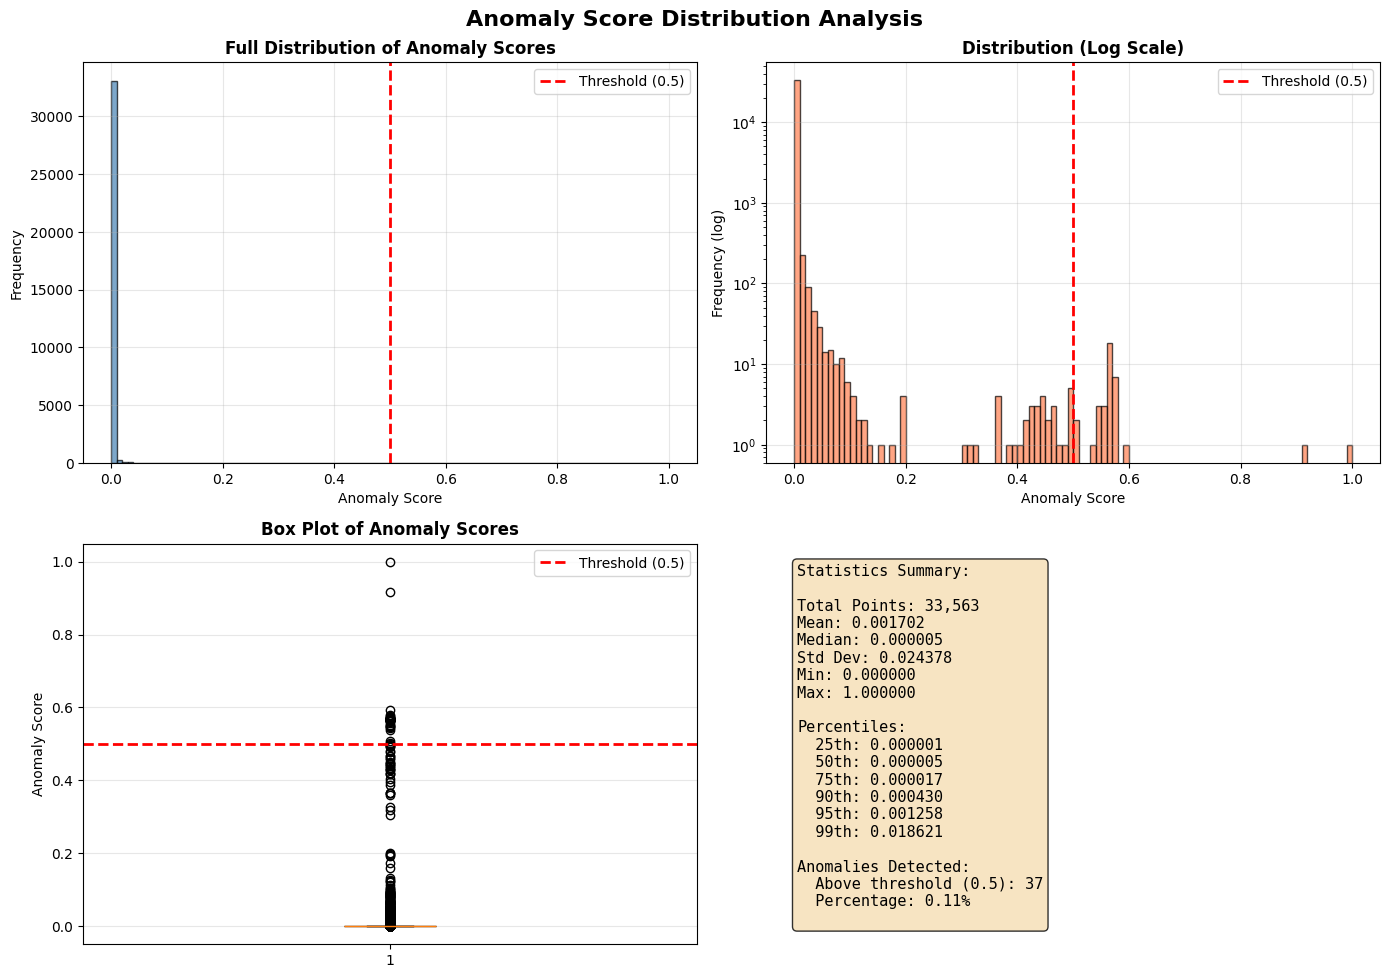

In [9]:
## plot distribution

import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots for distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Anomaly Score Distribution Analysis', fontsize=16, fontweight='bold')

# Plot 1: Histogram with all scores
axes[0, 0].hist(scores, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(absolute_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({absolute_threshold})')
axes[0, 0].set_title('Full Distribution of Anomaly Scores', fontweight='bold')
axes[0, 0].set_xlabel('Anomaly Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Log scale histogram (better for seeing the tail)
axes[0, 1].hist(scores, bins=100, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].set_yscale('log')
axes[0, 1].axvline(absolute_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({absolute_threshold})')
axes[0, 1].set_title('Distribution (Log Scale)', fontweight='bold')
axes[0, 1].set_xlabel('Anomaly Score')
axes[0, 1].set_ylabel('Frequency (log)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Box plot with statistics
box = axes[1, 0].boxplot(scores, vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
axes[1, 0].set_title('Box Plot of Anomaly Scores', fontweight='bold')
axes[1, 0].set_ylabel('Anomaly Score')
axes[1, 0].axhline(absolute_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({absolute_threshold})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Statistics summary
stats_text = f"""Statistics Summary:

Total Points: {len(scores):,}
Mean: {np.mean(scores):.6f}
Median: {np.median(scores):.6f}
Std Dev: {np.std(scores):.6f}
Min: {np.min(scores):.6f}
Max: {np.max(scores):.6f}

Percentiles:
  25th: {np.percentile(scores, 25):.6f}
  50th: {np.percentile(scores, 50):.6f}
  75th: {np.percentile(scores, 75):.6f}
  90th: {np.percentile(scores, 90):.6f}
  95th: {np.percentile(scores, 95):.6f}
  99th: {np.percentile(scores, 99):.6f}

Anomalies Detected:
  Above threshold ({absolute_threshold}): {domain_anomalies.sum()}
  Percentage: {domain_anomalies.sum() / len(scores) * 100:.2f}%
"""

axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes, 
                fontsize=11, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

=== Creating Visualizations ===
Creating visualizations with 33563 data points...


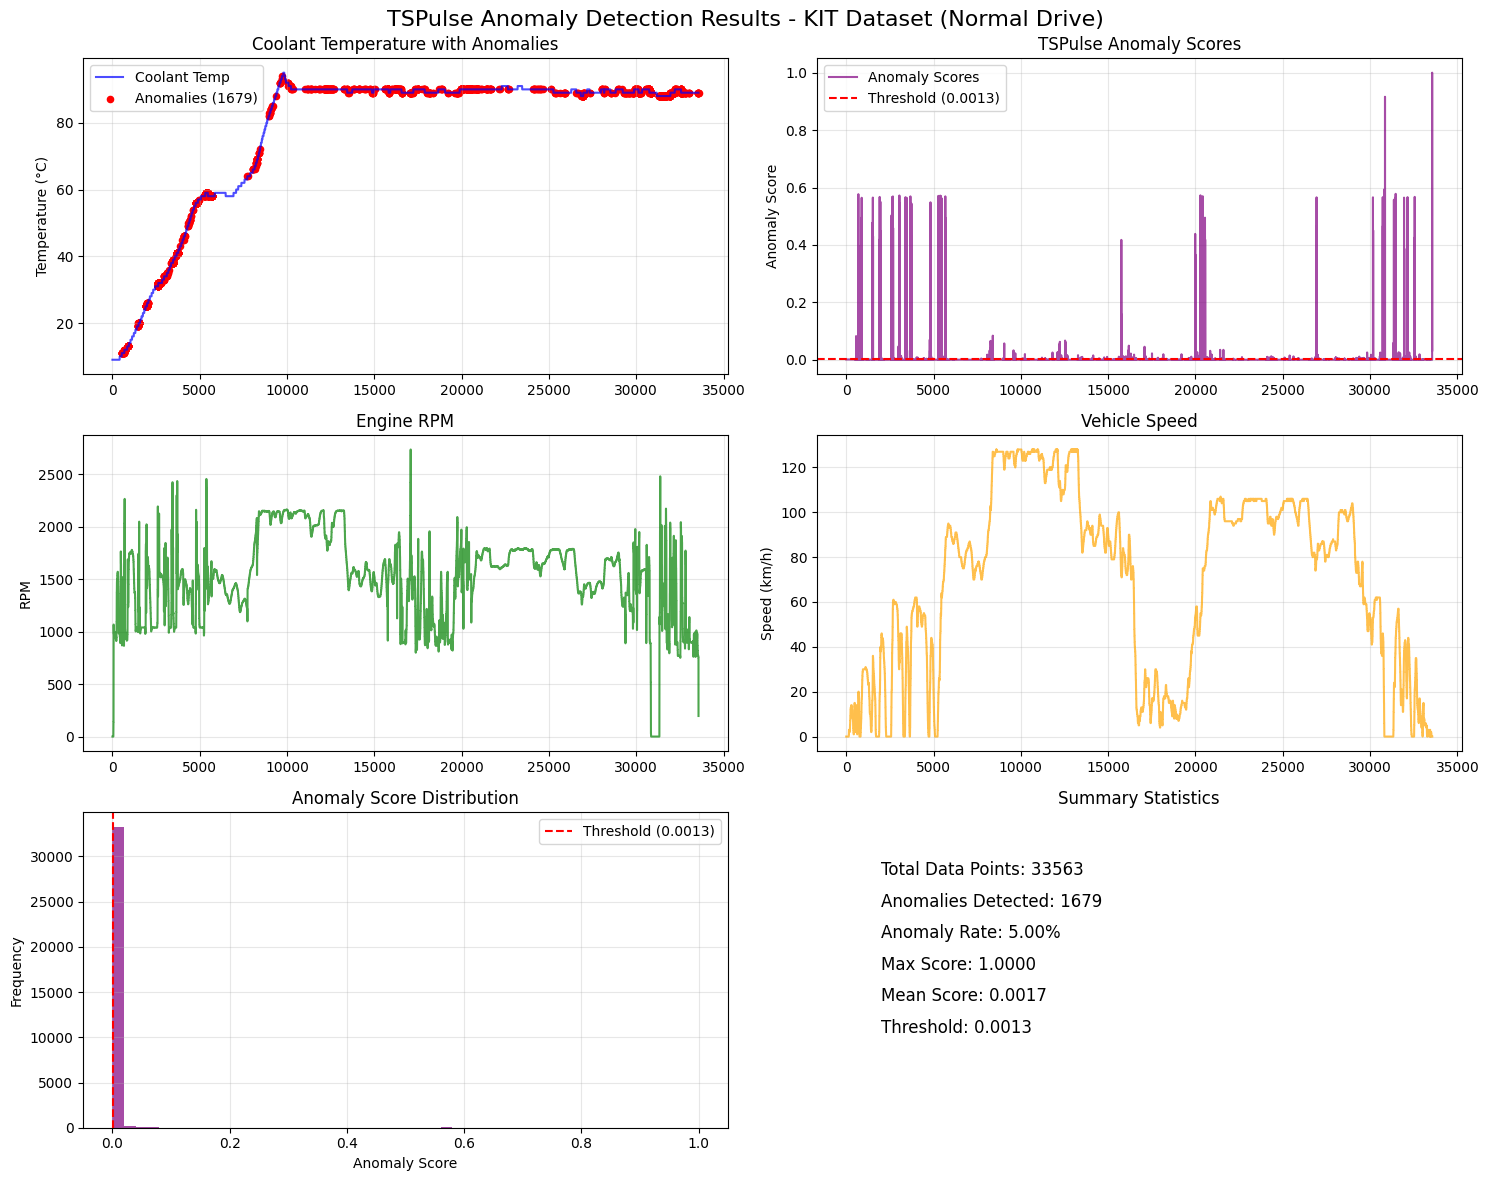

✅ TSPulse results saved to 'tspulse_coolant_anomaly_scores.csv'


In [10]:
# Visualization of TSPulse Results
print("=== Creating Visualizations ===")

# Check if we have valid results from the previous cells
if (kit_processed is not None and 
    'coolant_scores' in locals() and len(coolant_scores) > 0 and 
    'coolant_anomalies' in locals() and len(coolant_anomalies) > 0):
    
    print(f"Creating visualizations with {len(coolant_scores)} data points...")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('TSPulse Anomaly Detection Results - KIT Dataset (Normal Drive)', fontsize=16)
    
    # Plot 1: Coolant Temperature with Anomalies
    coolant_temp = kit_processed['Engine Coolant Temperature [°C]']
    axes[0, 0].plot(coolant_temp, alpha=0.7, label='Coolant Temp', color='blue')
    
    # Highlight anomalies
    coolant_anomaly_indices = np.where(coolant_anomalies)[0]
    if len(coolant_anomaly_indices) > 0:
        axes[0, 0].scatter(coolant_anomaly_indices, coolant_temp.iloc[coolant_anomaly_indices], color='red', s=20, label=f'Anomalies ({len(coolant_anomaly_indices)})')
    
    axes[0, 0].set_title('Coolant Temperature with Anomalies')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Anomaly Scores
    axes[0, 1].plot(coolant_scores, alpha=0.7, label='Anomaly Scores', color='purple')
    if 'threshold' in locals() and threshold > 0:
        axes[0, 1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
    axes[0, 1].set_title('TSPulse Anomaly Scores')
    axes[0, 1].set_ylabel('Anomaly Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Engine RPM
    rpm_col = 'Engine RPM [RPM]'
    if rpm_col in kit_processed.columns:
        axes[1, 0].plot(kit_processed[rpm_col], alpha=0.7, color='green')
        axes[1, 0].set_title('Engine RPM')
        axes[1, 0].set_ylabel('RPM')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Vehicle Speed
    speed_col = 'Vehicle Speed Sensor [km/h]'
    if speed_col in kit_processed.columns:
        axes[1, 1].plot(kit_processed[speed_col], alpha=0.7, color='orange')
        axes[1, 1].set_title('Vehicle Speed')
        axes[1, 1].set_ylabel('Speed (km/h)')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Anomaly Score Distribution
    axes[2, 0].hist(coolant_scores, bins=50, alpha=0.7, color='purple')
    if 'threshold' in locals() and threshold > 0:
        axes[2, 0].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
    axes[2, 0].set_title('Anomaly Score Distribution')
    axes[2, 0].set_xlabel('Anomaly Score')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: Summary Statistics
    total_anomalies = np.sum(coolant_anomalies)
    anomaly_rate = np.mean(coolant_anomalies) * 100
    
    axes[2, 1].text(0.1, 0.8, f'Total Data Points: {len(kit_processed)}', transform=axes[2, 1].transAxes, fontsize=12)
    axes[2, 1].text(0.1, 0.7, f'Anomalies Detected: {total_anomalies}', transform=axes[2, 1].transAxes, fontsize=12)
    axes[2, 1].text(0.1, 0.6, f'Anomaly Rate: {anomaly_rate:.2f}%', transform=axes[2, 1].transAxes, fontsize=12)
    axes[2, 1].text(0.1, 0.5, f'Max Score: {np.max(coolant_scores):.4f}', transform=axes[2, 1].transAxes, fontsize=12)
    axes[2, 1].text(0.1, 0.4, f'Mean Score: {np.mean(coolant_scores):.4f}', transform=axes[2, 1].transAxes, fontsize=12)
    if 'threshold' in locals() and threshold > 0:
        axes[2, 1].text(0.1, 0.3, f'Threshold: {threshold:.4f}', transform=axes[2, 1].transAxes, fontsize=12)
    axes[2, 1].set_title('Summary Statistics')
    axes[2, 1].set_xlim(0, 1)
    axes[2, 1].set_ylim(0, 1)
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df = pd.DataFrame({
        'anomaly_score': coolant_scores,
        'is_anomaly': coolant_anomalies,
        'coolant_temp': kit_processed['Engine Coolant Temperature [°C]']
    })
    
    # Save to CSV
    results_df.to_csv('tspulse_coolant_anomaly_scores.csv', index=False)
    print("✅ TSPulse results saved to 'tspulse_coolant_anomaly_scores.csv'")
    
else:
    print("❌ No valid data available for visualization")
    print("Please ensure Cell 7 and Cell 8 have been run successfully first")
    print(f"kit_processed available: {kit_processed is not None}")
    print(f"coolant_scores available: {'coolant_scores' in locals()}")
    if 'coolant_scores' in locals():
        print(f"coolant_scores length: {len(coolant_scores)}")
    print(f"coolant_anomalies available: {'coolant_anomalies' in locals()}")
    if 'coolant_anomalies' in locals():
        print(f"coolant_anomalies length: {len(coolant_anomalies)}")


In [11]:
# Final Evaluation and Summary
print("=== Final Evaluation Summary ===")

# Check if we have valid results from the TSPulse analysis
if (kit_processed is not None and 
    'coolant_scores' in locals() and len(coolant_scores) > 0 and 
    'coolant_anomalies' in locals() and len(coolant_anomalies) > 0):
    
    print("\n🎯 TSPulse Anomaly Detection Results for KIT Dataset")
    print("=" * 60)
    
    # Overall results
    total_points = len(coolant_scores)
    total_anomalies = np.sum(coolant_anomalies)
    anomaly_rate = np.mean(coolant_anomalies) * 100
    
    print(f"📊 Overall Results:")
    print(f"   • Total data points analyzed: {total_points:,}")
    print(f"   • Total anomalies detected: {total_anomalies:,}")
    print(f"   • Overall anomaly rate: {anomaly_rate:.2f}%")
    
    # Coolant-specific results
    coolant_anomalies_count = np.sum(coolant_anomalies)
    coolant_rate = np.mean(coolant_anomalies) * 100
    
    print(f"\n🌡️  Coolant Tempùùerature Sensor Results:")
    print(f"   • Coolant anomalies detected: {coolant_anomalies_count:,}")
    print(f"   • Coolant anomaly rate: {coolant_rate:.2f}%")
    if 'threshold' in locals():
        print(f"   • Threshold value: {threshold:.4f}")
    
    # Expected vs Actual
    print(f"\n✅ Expected vs Actual:")
    print(f"   • Expected anomaly rate: ~0% (normal drive, no faults)")
    print(f"   • Actual anomaly rate: {anomaly_rate:.2f}%")
    print(f"   • Coolant anomaly rate: {coolant_rate:.2f}%")
    
    # Performance assessment
    if anomaly_rate < 1.0:
        print(f"\n🎉 SUCCESS: Low anomaly detection rate ({anomaly_rate:.2f}%) indicates")
        print(f"   TSPulse correctly identifies normal driving patterns!")
    elif anomaly_rate < 5.0:
        print(f"\n⚠️  MODERATE: Some anomalies detected ({anomaly_rate:.2f}%) - may need")
        print(f"   threshold adjustment for normal driving data.")
    else:
        print(f"\n❌ HIGH: Many anomalies detected ({anomaly_rate:.2f}%) - may indicate")
        print(f"   model sensitivity issues or data preprocessing needs.")
    
    # Coolant sensor assessment
    if coolant_rate < 1.0:
        print(f"\n🌡️  Coolant Sensor: EXCELLENT - Very few anomalies ({coolant_rate:.2f}%)")
    elif coolant_rate < 5.0:
        print(f"\n🌡️  Coolant Sensor: GOOD - Some anomalies ({coolant_rate:.2f}%)")
    else:
        print(f"\n🌡️  Coolant Sensor: NEEDS ATTENTION - Many anomalies ({coolant_rate:.2f}%)")
    
    print(f"\n📈 Next Steps:")
    print(f"   1. ✅ Baseline established for normal driving data")
    print(f"   2. 🔄 Ready for synthetic fault injection testing")
    print(f"   3. 📊 Results saved to 'tspulse_coolant_anomaly_scores.csv'")
    print(f"   4. 🎯 Focus on coolant sensor for fault injection experiments")
    
else:
    print("❌ Error: Could not complete evaluation - data processing failed")
    print("Please ensure all previous cells have been run successfully")
    print(f"kit_processed available: {kit_processed is not None}")
    print(f"coolant_scores available: {'coolant_scores' in locals()}")
    if 'coolant_scores' in locals():
        print(f"coolant_scores length: {len(coolant_scores)}")
    print(f"coolant_anomalies available: {'coolant_anomalies' in locals()}")
    if 'coolant_anomalies' in locals():
        print(f"coolant_anomalies length: {len(coolant_anomalies)}")

print("\n" + "="*60)
print("TSPulse Anomaly Detection Complete!")
print("="*60)


=== Final Evaluation Summary ===

🎯 TSPulse Anomaly Detection Results for KIT Dataset
📊 Overall Results:
   • Total data points analyzed: 33,563
   • Total anomalies detected: 1,679
   • Overall anomaly rate: 5.00%

🌡️  Coolant Tempùùerature Sensor Results:
   • Coolant anomalies detected: 1,679
   • Coolant anomaly rate: 5.00%
   • Threshold value: 0.0013

✅ Expected vs Actual:
   • Expected anomaly rate: ~0% (normal drive, no faults)
   • Actual anomaly rate: 5.00%
   • Coolant anomaly rate: 5.00%

❌ HIGH: Many anomalies detected (5.00%) - may indicate
   model sensitivity issues or data preprocessing needs.

🌡️  Coolant Sensor: NEEDS ATTENTION - Many anomalies (5.00%)

📈 Next Steps:
   1. ✅ Baseline established for normal driving data
   2. 🔄 Ready for synthetic fault injection testing
   3. 📊 Results saved to 'tspulse_coolant_anomaly_scores.csv'
   4. 🎯 Focus on coolant sensor for fault injection experiments

TSPulse Anomaly Detection Complete!
